# Imports

In [4]:
import spacy
from spacy.tokens.doc import Doc
import pandas as pd
from collections import Counter, defaultdict
from datetime import datetime
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import nltk

In [5]:
nlp = spacy.load('en')

In [6]:
test_loc = 'test_dump.bin'
train_loc = 'train_dump.bin'

# Read data

In [7]:
train = pd.read_csv('../data/train.csv').fillna('')
test = pd.read_csv('../data/test.csv').fillna('')
print train.shape, test.shape

(404290, 6) (2345796, 3)


In [8]:
target = list(train['is_duplicate'])

# Read training data
Elements $(2n, 2n+1)$ are the questions for pair $n$

In [9]:
docs = []
i = 0
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
with open(train_loc, 'rb') as file_:
    for byte_string in Doc.read_bytes(file_):
        if i%10000 == 0: print i, datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        docs.append(Doc(nlp.vocab).from_bytes(byte_string))
        i += 1
#         if i == 10: break
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(type(docs[0]))

2017-05-15 10:47:55
0 2017-05-15 10:47:55
10000 2017-05-15 10:47:58
20000 2017-05-15 10:47:59
30000 2017-05-15 10:48:00
40000 2017-05-15 10:48:00
50000 2017-05-15 10:48:01
60000 2017-05-15 10:48:02
70000 2017-05-15 10:48:03
80000 2017-05-15 10:48:04
90000 2017-05-15 10:48:05
100000 2017-05-15 10:48:05
110000 2017-05-15 10:48:06
120000 2017-05-15 10:48:07
130000 2017-05-15 10:48:08
140000 2017-05-15 10:48:09
150000 2017-05-15 10:48:10
160000 2017-05-15 10:48:11
170000 2017-05-15 10:48:11
180000 2017-05-15 10:48:12
190000 2017-05-15 10:48:13
200000 2017-05-15 10:48:14
210000 2017-05-15 10:48:15
220000 2017-05-15 10:48:15
230000 2017-05-15 10:48:16
240000 2017-05-15 10:48:17
250000 2017-05-15 10:48:18
260000 2017-05-15 10:48:19
270000 2017-05-15 10:48:19
280000 2017-05-15 10:48:20
290000 2017-05-15 10:48:21
300000 2017-05-15 10:48:22
310000 2017-05-15 10:48:22
320000 2017-05-15 10:48:23
330000 2017-05-15 10:48:24
340000 2017-05-15 10:48:25
350000 2017-05-15 10:48:26
360000 2017-05-15 10:4

In [10]:
docs[5].ents

(DNS,)

In [11]:
def covertPropn(pos):
    if pos == u'PROPN':
        return u'NOUN'
    else: return pos

In [294]:
from nltk.tag import mapping
from itertools import product
from nltk.corpus import wordnet as wn
import numpy as np
from nltk.wsd import lesk


def sim(s1, s2):
#     if (s1, s2) in cache:
#         return cache[(s1, s2)]
#     else:
    try: return wn.wup_similarity(s1, s2)
    except Exception as e: 
        print 'e::', e, s1, s2
#     cache[(s1, s2)] = sim 
    
    
def leskify(lemma, pos, sentence):
#     print lemma, pos
    mapping = {'NOUN': 'n', 'ADJ':'a', 'ADV':'r', 'VERB':'v', 'PRON':'n', 'ADP':'p', 'DET':'n'}
    m = mapping[pos]
    l = lesk(sentence, lemma, m)
    return l
    
def wnSim(w1, w2):
    fillin = .5
    w1 = set([(word.lemma_, covertPropn(word.pos_)) for word in w1])
    w2 = set([(word.lemma_, covertPropn(word.pos_)) for word in w2])
    sentence1 = w1 - w2
    sentence2 = w2 - w1
    sentence = w1 | w2
    if len(sentence1) == 0 or len(sentence2) == 0: return fillin
    allsyns1 = set(leskify(w[0], w[1], sentence) for w in sentence1)
    allsyns1 = set([a for a in allsyns1 if a])
#     print sentence1, sentence2
#     print 'allsyns:', allsyns1
    if len(allsyns1) == 0: return fillin
    ysets = [leskify(w[0], w[1], sentence) for w in sentence2]
    ysets = [y for y in ysets if y]
#     print ysets
    maxes = [max((sim(s1, s2) or 0) for s1, s2 in product(allsyns1, [y])) for y in ysets if y]
    return np.mean(maxes)

In [295]:
d1 = nlp(u"I ran fast to the store to buy eggs")
d2 = nlp(u'He ran after waffles quickly and happily inside the shop')
w1 = [w for w in d1 if not w.is_stop and w.pos is not 95]
w2 = [w for w in d2 if not w.is_stop and w.pos is not 95]
wnSim(w1, w2)

0.28125

In [ ]:
def countQuestionPairs(docs):
    invalids = [95, 91, 99, 87, 89, 92, 97, 101]
    fvs = []
    for i in range(0,len(docs),2):
        if i % 100000 == 0: print i
        fv = defaultdict(int) 
        d1 = docs[i]
        d2 = docs[i+1]

        s1 = set(list(str(e) for e in d1.ents))
        s2 = set(list(str(e) for e in d2.ents))

        sameents = len(s1 & s2)
        diffents = len(s1 ^ s2)
        fv['sameents'] = sameents
        fv['diffents'] = diffents
        
        w1 = [w for w in d1 if not w.is_stop and w.pos not in invalids]
        w2 = [w for w in d2 if not w.is_stop and w.pos not in invalids]
        
        us1 = set([(covertPropn(word.pos_), word.lemma_) for word in w1])
        us2 = set([(covertPropn(word.pos_), word.lemma_) for word in w2])
        udiff = us1 ^ us2
        usame =  us1 & us2
        
        usamenum = len(usame)
        fv['usamenum'] = usamenum
        usame = Counter([t[0] for t in usame])
        fv.update(usame)

        udiffnum = len(udiff)
        fv['udiffnum'] = udiffnum
#         if (len(us1) + len(us2)) > 0: 
#             fv['ujackard'] = usamenum/float(len(us1) + len(us2))
        udiff = Counter([t[0] + '_d' for t in udiff])
        fv.update(udiff)
        fv['wn'] = wnSim(w1, w2)
        
#         w1 = [w[1] for w in w1]
#         w2 = [w[1] for w in w2]
#         bs1 = set(nltk.bigrams(w1))
#         bs2 = set(nltk.bigrams(w2))
#         bsame =  bs1 & bs2
#         fv['bsame'] = len(bsame)
#         if (len(bs1) + len(bs2)) > 0: 
#             fv['bjackard'] = len(bsame)/float(len(bs1) + len(bs2)) 
        
#         ts1 = set(nltk.ngrams(w1,3))
#         ts2 = set(nltk.ngrams(w2,3))
# #         print w1
# #         print ts1
#         tsame =  ts1 & ts2
#         fv['tsame'] = len(tsame)
#         if (len(ts1) + len(ts2)) > 0: 
#             fv['tjackard'] = len(tsame)/float(len(ts1) + len(ts2))
#         if i > 100: return fvs
#         print fv
        fvs.append(fv)
    return fvs

In [ ]:
fvs = countQuestionPairs(docs)

In [215]:
for i, f in enumerate(fvs[:900]):
    print f
#     print docs[2 *i], docs[2 *i + 1]
#     print target[i]

defaultdict(<type 'int'>, {'sameents': 0, 'udiffnum': 1, 'usamenum': 5, 'wn': 0.5, 'diffents': 0, u'VERB': 1, u'NOUN': 4, u'NOUN_d': 1})
defaultdict(<type 'int'>, {'sameents': 2, 'udiffnum': 5, 'usamenum': 4, u'ADJ_d': 1, 'wn': 0.24444444444444446, u'VERB_d': 2, 'diffents': 1, u'NOUN': 4, u'NOUN_d': 2})
defaultdict(<type 'int'>, {'sameents': 0, u'PRON_d': 1, 'udiffnum': 6, 'usamenum': 2, 'wn': 0.5, u'VERB_d': 1, 'diffents': 2, u'VERB': 1, u'NOUN': 1, u'NOUN_d': 4})
defaultdict(<type 'int'>, {'sameents': 0, u'ADV_d': 1, 'udiffnum': 7, 'usamenum': 0, u'ADJ_d': 1, 'wn': 0.26111111111111107, u'VERB_d': 3, 'diffents': 1, u'NOUN_d': 2})
defaultdict(<type 'int'>, {'sameents': 0, 'udiffnum': 8, 'usamenum': 2, u'ADJ_d': 1, 'wn': 0.34848484848484851, u'VERB_d': 2, 'diffents': 0, u'NOUN': 2, u'NOUN_d': 5})
defaultdict(<type 'int'>, {'sameents': 0, 'udiffnum': 6, 'usamenum': 3, u'ADJ_d': 2, 'wn': 1.0, u'VERB_d': 2, 'diffents': 4, u'NOUN': 3, u'NOUN_d': 2})
defaultdict(<type 'int'>, {'sameents': 0,

In [82]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
X = v.fit_transform(fvs)

In [83]:
n_estimators = 20
clfs = [RandomForestClassifier(min_samples_leaf=20, min_samples_split=10, n_jobs=-1), MultinomialNB(), SGDClassifier(loss='log'), LogisticRegression()]
# clfs = [SVC(kernel='linear', probability=True)] 

for clf in clfs:
    print clf
    scores = cross_val_score(clf, X, target, cv=3, scoring='neg_log_loss')
    print "Log Loss: %0.5f" % scores.mean()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Log Loss: -0.50130
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Log Loss: -0.92024
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Log Loss: -0.55561
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='li

In [78]:
n_estimators = 20
clfs = [RandomForestClassifier(n_estimators= 50, min_samples_leaf=7, min_samples_split=30, n_jobs=-1, warm_start=True)]
# clfs = [SVC(kernel='linear', probability=True)] 

for clf in clfs:
    print clf
    scores = cross_val_score(clf, X, target, cv=3, scoring='neg_log_loss')
    print "Log Loss: %0.5f" % scores.mean()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=7,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)
Log Loss: -0.49346


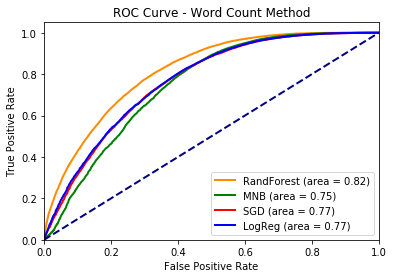

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)
clfs = clfs = [('RandForest',RandomForestClassifier(min_samples_leaf=20, min_samples_split=10, n_jobs=-1)), ('MNB', MultinomialNB(alpha=1)), ('SGD', SGDClassifier(loss='log')), ('LogReg', LogisticRegression())]
colors = cycle(['darkorange','green', 'red', 'blue'])

for (clfname, clf), color in zip(clfs, colors):
    y_score = zip(*clf.fit(X_train, y_train).predict_proba(X_test))[1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    rocauc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color=color, lw=lw, label=clfname + ' (area = %0.2f)' % rocauc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Word Count Method')
plt.legend(loc="lower right")
plt.savefig("roc_wc.pdf")
plt.show()

# Read test questions

In [ ]:
test_docs = []
i = 0
with open(test_loc, 'rb') as file_:
    for byte_string in Doc.read_bytes(file_):
        test_docs.append(Doc(nlp.vocab).from_bytes(byte_string))
        i += 1
print(type(test_docs[0]))

In [ ]:
test_docs[1345288]

In [ ]:
test_fvs = countQuestionPairs(test_docs)